In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
#Import database
fifa_df = pd.read_csv('fifa21data.csv')
#Show features/attributes we can choose from
fifa_df.info()

#Delete columns that show photos & urls of players
fifa_df = fifa_df.drop(["photoUrl","playerUrl"],axis=1)

# Remove rows using negation that are duplicates based on name
fifa_df=fifa_df[~fifa_df.duplicated(subset=["Name"])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 66 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                18979 non-null  int64 
 1   Name              18979 non-null  object
 2   LongName          18979 non-null  object
 3   photoUrl          18979 non-null  object
 4   playerUrl         18979 non-null  object
 5   Nationality       18979 non-null  object
 6   Age               18979 non-null  int64 
 7   OVA               18979 non-null  int64 
 8   POT               18979 non-null  int64 
 9   Club              18979 non-null  object
 10  Height            18979 non-null  object
 11  Weight            18979 non-null  object
 12  Preferred Foot    18979 non-null  object
 13  BOV               18979 non-null  int64 
 14  Best Position     18979 non-null  object
 15  Joined            18979 non-null  object
 16  Loan Date End     1013 non-null   object
 17  Value       

In [3]:
#We create a function to convert values of strings to numerical value
def convert_to_numeric(value_str):
    #Remove EUR symbol
    value_str=value_str.replace('€','').replace(',','')
    
    #Replace prefix letter by blank, then convert it to numerical * prefix value
    if 'K' in value_str:
        return float(value_str.replace("K","")) * 1.0e3
    elif "M" in value_str:
        return float(value_str.replace('M','')) * 1.0e6
    else:
        return float(value_str)

In [4]:
#We implement our function

#To show the table we're about to change (first 5 rows)
print(f'Table before changing prefixes:\n{fifa_df[["Value","Wage"]].head(5)}')

#We convert the features to numerical that are subject to prefix problems
fifa_df["Wage"]=fifa_df["Wage"].apply(convert_to_numeric)
fifa_df["Value"]=fifa_df["Value"].apply(convert_to_numeric)

#Get table to see how everything has changed
print(f'Table after changing prefixes:\n{fifa_df[["Value","Wage"]].head(5)}')

Table before changing prefixes:
     Value   Wage
0  €103.5M  €560K
1     €63M  €220K
2    €120M  €125K
3    €129M  €370K
4    €132M  €270K
Table after changing prefixes:
         Value      Wage
0  103500000.0  560000.0
1   63000000.0  220000.0
2  120000000.0  125000.0
3  129000000.0  370000.0
4  132000000.0  270000.0


In [5]:
#Create model based on 4 features - overall rating, potential, age and nationality of player

# We have to convert the nationalities into numbers, as linear regression doesn't deal with strings (label encoding)

# Create Label Encoder object
le = LabelEncoder()
# Label encode nationality column and save values at label
label = le.fit_transform(fifa_df["Nationality"])
# Create new column called nationality based on label values
fifa_df["Nat_label"] = label

# Print table with nationality & label 
print(fifa_df[["OVA","POT","Age","Nationality","Nat_label"]].head(5))
# Create training set
training_set = fifa_df[["OVA","POT","Age","Nat_label"]]
print(training_set)

# Create linear regression object
model = LinearRegression()
# Train our model
model.fit(training_set.values,fifa_df["Value"])
# Print equation of slope
print(f"Model equation: {model.coef_} * X + {model.intercept_}")

   OVA  POT  Age Nationality  Nat_label
0   93   93   33   Argentina          6
1   92   92   35    Portugal        122
2   91   93   27    Slovenia        137
3   91   91   29     Belgium         14
4   91   91   28      Brazil         20
       OVA  POT  Age  Nat_label
0       93   93   33          6
1       92   92   35        122
2       91   93   27        137
3       91   91   29         14
4       91   91   28         20
...    ...  ...  ...        ...
18974   47   55   21         30
18975   47   67   17         47
18976   47   65   18         47
18977   47   57   20         30
18978   47   57   21         30

[17920 rows x 4 columns]
Model equation: [ 6.42367116e+05  1.53786902e+05 -3.21688670e+05 -6.45881041e+00] * X + -42198505.88496359


In [6]:
# We predict price players with same skillset but different nationalities based on data we set

# Set arbitrary attributes to test our model
OVA = 60
POT = 80
Age = 19
Nat = 90
features = np.array([[OVA,POT,Age,Nat]])
print(f"Predicted price for player: {round(model.predict(features)[0])}€")
print(f'Cost of our model: {mean_squared_error(fifa_df["Value"],model.predict(training_set.values))}')

Predicted price for player: 2533807€
Cost of our model: 38939134059766.43


In [7]:
# In order to represent nationality-price pairs based on the frequency of nationalities, we have to make the following table:

# Sort nationality based on frequency
Nat_plus_label = fifa_df[["Nationality","Nat_label"]].value_counts().reset_index()
# Get unique nationality-label pairs
Nat_plus_label = Nat_plus_label.drop_duplicates()
prices = []
print(Nat_plus_label)
# Repeat as many iterations as there are unique countries
# Get price for player with same skillset but different country & add it to prices array
for n in range(Nat_plus_label.shape[0]):
    features[0][3] = Nat_plus_label["Nat_label"].iloc[n]
    player_price = np.round(model.predict(features)[0],1)
    prices.append(player_price)

# Add price values for our dataset
Nat_plus_label["Price"] = np.array(prices).tolist()
# Represent top 15 nations
top_nats = Nat_plus_label.head(15)
print(top_nats)

          Nationality  Nat_label  count
0             England         47   1574
1             Germany         58   1178
2               Spain        140   1019
3              France         54    971
4           Argentina          6    861
..                ...        ...    ...
157       Puerto Rico        123      1
158         Korea DPR         83      1
159  Papua New Guinea        117      1
160            Malawi         95      1
161             Malta         98      1

[162 rows x 3 columns]
      Nationality  Nat_label  count      Price
0         England         47   1574  2534084.9
1         Germany         58   1178  2534013.9
2           Spain        140   1019  2533484.2
3          France         54    971  2534039.7
4       Argentina          6    861  2534349.7
5          Brazil         20    821  2534259.3
6           Japan         79    463  2533878.2
7     Netherlands        107    435  2533697.4
8           Italy         76    382  2533897.6
9          Sweden        1

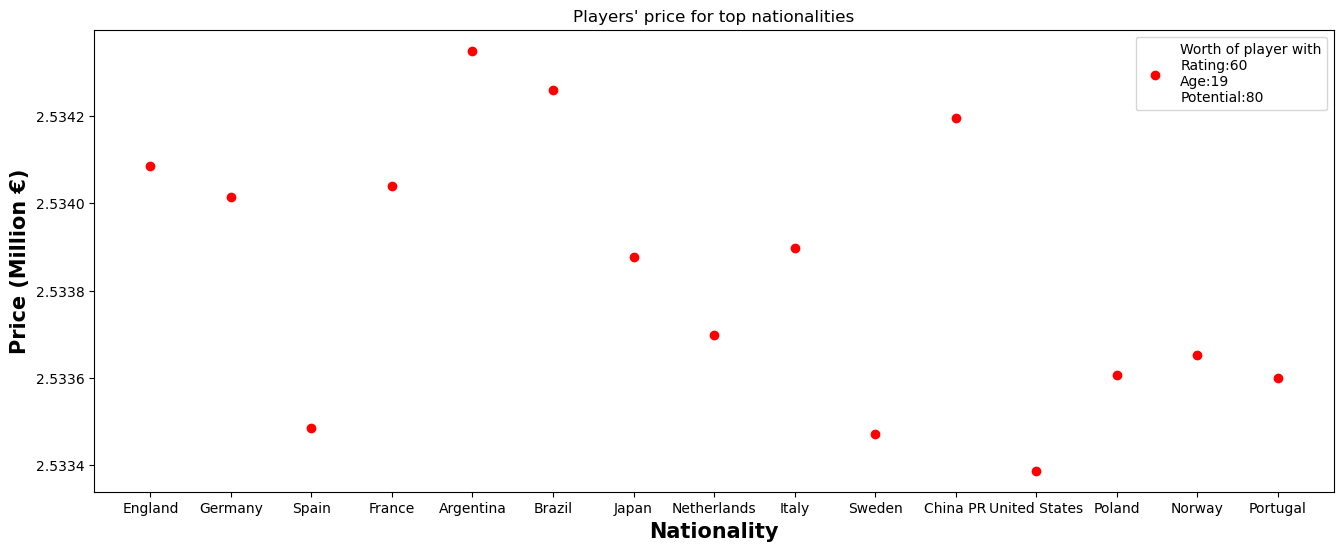

In [8]:
#Plot results
plt.figure(figsize=(16,6))
plt.scatter(top_nats["Nationality"],top_nats["Price"]/1e6,c="red",label=f"Worth of player with\nRating:{OVA}\nAge:{Age}\nPotential:{POT}")
plt.title("Players' price for top nationalities")
plt.xlabel("Nationality", fontweight="bold",fontsize=15)
plt.ylabel("Price (Million €)", fontweight="bold",fontsize=15)

plt.legend()
plt.show()